# Electricity Theft Detection with Real-Time Input using XGBoost


This notebook implements an electricity theft detection pipeline based on the SGCC dataset, using XGBoost for dimensionality reduction. It includes support for:
- Data cleaning and preprocessing
- Synthetic data generation for class balancing
- Feature extraction (time and frequency domain)
- Hyperparameter tuning with Bayesian optimization
- Real-time classification for new consumption records


In [1]:

# !pip install pandas numpy scikit-learn tensorflow scikit-optimize matplotlib


In [21]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.fft import fft
from scipy.interpolate import PchipInterpolator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score
from skopt import gp_minimize
from sklearn.preprocessing import StandardScaler
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from imblearn.over_sampling import SMOTE


In [3]:

# The original State Grid Corporation of China (SGCC) dataset used for training models in this project 
# contains 42,372 rows and 1,036 columns. It was utilized for extensive data cleaning and 
# feature selection to train the XGBoost model.

# Due to its large size (~163 MB), it cannot be hosted directly on GitHub, 
# but it is available on Kaggle: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset

# For demonstration and preview purposes, refer to `Electricity_Theft_XGBoost_Data_Cleaning_Small_Dataset_Pipeline.ipynb` located in the `/data/raw` directory.

# Load the dataset
df = pd.read_csv('../data/raw/dataset.csv')  


In [ ]:

# I will drop the CONS_NO column since it seems to provide no information as well as being of string type
df = df.drop("CONS_NO", axis=1)

df = df[(df.iloc[:, 1:-1] != 0).any(axis=1)]

def interpolate_row(row):
    x = np.arange(len(row))
    valid = ~row.isna()
    if valid.sum() < 2:
        return row
    f = PchipInterpolator(x[valid], row[valid])
    return pd.Series(f(x))

usage_data = df.iloc[:, 1:-1]
usage_data = usage_data.apply(interpolate_row, axis=1)
df.iloc[:, 1:-1] = usage_data


In [4]:

# Synthetic data generation for class balancing
def generate_synthetic_samples(df_clean, target_col='FLAG'):
    majority = df_clean[df_clean[target_col] == 0]
    minority = df_clean[df_clean[target_col] == 1]
    diff = len(majority) - len(minority)
    if diff <= 0:
        return df_clean
    synthetic = majority.sample(n=diff, random_state=42).copy()
    synthetic_data = synthetic.iloc[:, 1:-1].values * np.random.rand(diff, synthetic.shape[1] - 2)

    synthetic_df = pd.DataFrame(synthetic_data, columns=synthetic.columns[1:-1])
    synthetic_df['FLAG'] = 1
    return pd.concat([df_clean, synthetic_df], ignore_index=True)

df['FLAG'] = df['FLAG'].astype(int)
df = generate_synthetic_samples(df)

# --- Check Balance ---
print("Class distribution after addition:")
print(df['FLAG'].value_counts())


Class distribution after addition:
FLAG
1    38757
0    38757
Name: count, dtype: int64


In [5]:

df.info


<bound method DataFrame.info of        1/1/2014      1/2/2014       1/3/2014      1/4/2014    1/5/2014  \
0           0.0  0.000000e+00       0.010000  0.000000e+00    0.000000   
1           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
2           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
3           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
4           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
...         ...           ...            ...           ...         ...   
77509       NaN  3.992012e+06  355886.919680  2.821497e+06  164.236538   
77510       NaN  1.540747e+01      13.016436  6.808182e+00    9.975752   
77511       NaN  7.233658e+00       1.854659  5.471739e+00    4.491600   
77512       NaN  1.705002e-02       0.032311  1.302021e+00    1.220575   
77513       NaN  1.591562e+00       2.085901  4.065039e-01    0.944656   

            1/6/2014      1/7/2014      1/8/2014      1/9/2014     1/10/2014  \

In [6]:

# Check the number of instances of each class
class_counts = df['FLAG'].value_counts()
class_counts


FLAG
1    38757
0    38757
Name: count, dtype: int64

Text(0.5, 1.0, 'FLAG Imbalanced Distribution')

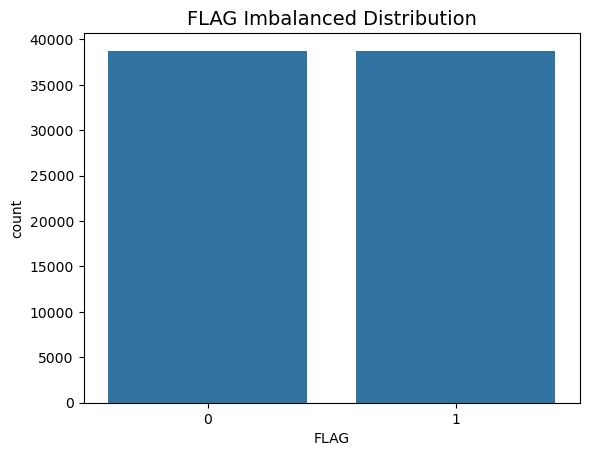

In [22]:

# Now having a balance label
sns.countplot(x=df['FLAG'])
plt.title('FLAG Imbalanced Distribution', fontsize=14)


In [8]:

# Get the number of missing values and percentage
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)

# Assuming your DataFrame is named "data"
missing_values = df.isna().sum()

# To get the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

print("Missing values per column:")
print([x for x in missing_values if x!=0])
print("Total missing values in the DataFrame:", total_missing_values)


1/1/2014      66.625384
1/2/2014       0.009031
1/3/2014       0.009031
1/4/2014       0.009031
1/5/2014       0.009031
                ...    
10/28/2016     0.009031
10/29/2016     0.009031
10/30/2016     0.009031
10/31/2016     0.009031
FLAG           0.000000
Length: 1035, dtype: float64
Missing values per column:
[51644, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [9]:

# Check for columns with missing values
columns_with_missing_values = df.columns[df.isna().any()].tolist()


## Data Cleaning

In [10]:

# Filling missing values with interpolation
df = df.interpolate(method='linear', axis=0)


In [11]:

# Now we check if there's any missing data left
missing_values = df.isna().sum()
print(missing_values.sum())
columns_with_missing_values = df.columns[df.isna().any()].tolist()
print(columns_with_missing_values)


0
[]


In [12]:

df.info


<bound method DataFrame.info of        1/1/2014      1/2/2014       1/3/2014      1/4/2014    1/5/2014  \
0           0.0  0.000000e+00       0.010000  0.000000e+00    0.000000   
1           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
2           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
3           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
4           0.0  0.000000e+00       0.000000  0.000000e+00    0.000000   
...         ...           ...            ...           ...         ...   
77509    3318.0  3.992012e+06  355886.919680  2.821497e+06  164.236538   
77510    3318.0  1.540747e+01      13.016436  6.808182e+00    9.975752   
77511    3318.0  7.233658e+00       1.854659  5.471739e+00    4.491600   
77512    3318.0  1.705002e-02       0.032311  1.302021e+00    1.220575   
77513    3318.0  1.591562e+00       2.085901  4.065039e-01    0.944656   

            1/6/2014      1/7/2014      1/8/2014      1/9/2014     1/10/2014  \

In [13]:

# Feature extraction (time and frequency domain)
def extract_features(row):
    time = row.values
    freq = np.abs(fft(time))[:len(time)//2]
    return pd.Series({
        'energy_mean': time.mean(),
        'energy_std': time.std(),
        'energy_max': time.max(),
        'energy_min': time.min(),
        'energy_range': time.max() - time.min(),
        'energy_freq_mean': freq.mean(),
        'energy_freq_std': freq.std(),
        'energy_freq_max': freq.max(),
        'energy_freq_min': freq.min()
    })

features = df.apply(extract_features, axis=1)


In [14]:

# Adding FLAG Column as Target
features['FLAG'] = df['FLAG']


In [15]:

# Save and Preview
# features.to_csv('../data/processed/extract_features_data.csv', index=False) #Uncomment to save file

print("List of Extracted Features Dataset:")
print(features.columns.tolist())
print(features.head())


List of Extracted Features Dataset:
['energy_mean', 'energy_std', 'energy_max', 'energy_min', 'energy_range', 'energy_freq_mean', 'energy_freq_std', 'energy_freq_max', 'energy_freq_min', 'FLAG']
   energy_mean  energy_std  energy_max  energy_min  energy_range  \
0     0.951231    3.099215       18.29         0.0         18.29   
1     4.312530    6.888938       44.57         0.0         44.57   
2     8.719317    9.947823       79.71         0.0         79.71   
3     3.776809    8.053526       40.98         0.0         40.98   
4    73.737744   43.411340      399.40         0.0        399.40   

   energy_freq_mean  energy_freq_std  energy_freq_max  energy_freq_min  FLAG  
0         42.991075        99.887367       984.524059         0.388660     1  
1         83.327368       284.178032      4463.468775         2.507727     1  
2        212.764794       463.409287      9024.493428         4.580813     1  
3         86.475023       298.784065      3908.997452         0.386808     1  
4

In [16]:

features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77514 entries, 0 to 77513
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy_mean       77514 non-null  float64
 1   energy_std        77514 non-null  float64
 2   energy_max        77514 non-null  float64
 3   energy_min        77514 non-null  float64
 4   energy_range      77514 non-null  float64
 5   energy_freq_mean  77514 non-null  float64
 6   energy_freq_std   77514 non-null  float64
 7   energy_freq_max   77514 non-null  float64
 8   energy_freq_min   77514 non-null  float64
 9   FLAG              77514 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 5.9 MB
